# Vaje 4: Posebnosti binarne klasifikacije in odločitvena drevesa

## Naloga 1: Mere kakovosti

In [1]:
import numpy as np

data = np.load("vaje4_1.npy")
X = data[:, :-1]
y =data[:, -1].astype(bool)



1.a: Najdi najboljšo vrednost parametra k za napovedni model k najbližjih sosedov v primeru, ko za mero kakovosti izberemo natančnost (precision), priklic, ali ploščino pod ROC krivuljo (AUC ROC). Za oceno napake uporabi 5 kratno prečno preverjanje.

<details>
  <summary>Namig:</summary>

  *Pomagaj si s [funkcijami sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), [sklearn.metrics.recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html), [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).
   
</details>

In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold()
k_values = range(1, 31)  # poskusi k od 1 do 30
precision_scores = []
recall_scores = []
auc_scores = []


for k in k_values:
     
     model = KNeighborsClassifier(n_neighbors=k)

     precision_fold = []
     recall_fold = []
     auc_fold = []

     for ind_train, ind_test in skf.split(X, y):
         
         X_train, X_test = X[ind_train], X[ind_test]
         y_train, y_test = y[ind_train], y[ind_test]

         model.fit(X_train, y_train)
         y_pred = model.predict(X_test)
         y_prob = model.predict_proba(X_test)[:, 1]
        
         precision_fold.append(precision_score(y_test, y_pred, zero_division=0))
         recall_fold.append(recall_score(y_test, y_pred, zero_division=0))
         auc_fold.append(roc_auc_score(y_test, y_prob))

     precision_scores.append(np.mean(precision_fold))
     recall_scores.append(np.mean(recall_fold))
     auc_scores.append(np.mean(auc_fold))




# Poišči najboljše vrednosti k
best_k_precision = k_values[np.argmax(precision_scores)]
best_k_recall = k_values[np.argmax(recall_scores)]
best_k_auc = k_values[np.argmax(auc_scores)]

print(f"Najboljši k glede na precision: {best_k_precision} (vrednost = {max(precision_scores):.3f})")
print(f"Najboljši k glede na recall: {best_k_recall} (vrednost = {max(recall_scores):.3f})")
print(f"Najboljši k glede na AUC ROC: {best_k_auc} (vrednost = {max(auc_scores):.3f})")





Najboljši k glede na precision: 28 (vrednost = 0.734)
Najboljši k glede na recall: 3 (vrednost = 0.408)
Najboljši k glede na AUC ROC: 20 (vrednost = 0.596)


1.b: Najdi najboljšo vrednost parametra k v primeru, ko za mero kakovosti izberemo najmanjšo ceno modela, kjer predpostavljamo, da je napaka tipa 1 dvakrat dražja od napake tipa 2. Napako tipa 1 (zmotno pozitivni, FP)  merite kot delež tistih negativnih primerov, ki so bili zmotno razglašeni za pozitivne. Analogno definirajte napako tipa 2 (zmotno negativni FN). Končna napaka naj bo torej vsota 2 N1 + N2. Postopate lahko podobno kot zgoraj pri natančnosti. Pomagaš si lahko s funkcijama `numpy.logical_not` in `numpy.logical_and`.

In [3]:
skf = StratifiedKFold()
k_values = range(1, 31)  # poskusi k od 1 do 30
cost_scores = []


for k in k_values:
     
     model = KNeighborsClassifier(n_neighbors=k)

     fold_costs = []

     for ind_train, ind_test in skf.split(X, y):
         
         X_train, X_test = X[ind_train], X[ind_test]
         y_train, y_test = y[ind_train], y[ind_test]

         model.fit(X_train, y_train)
         y_pred = model.predict(X_test)
         y_prob = model.predict_proba(X_test)[:, 1]

          # Napake tipa 1 (FP): y_test = 0, y_pred = 1
         FP = np.logical_and(y_test == 0, y_pred == 1).sum()
          # Napake tipa 2 (FN): y_test = 1, y_pred = 0
         FN = np.logical_and(y_test == 1, y_pred == 0).sum()

         N1 = FP/sum(y_test == 0)
         N2 = FN/sum(y_test == 1)

         cost = 2 * N1 + N2
         fold_costs.append(cost)

     cost_scores.append(np.mean(fold_costs))



# Poišči najboljše vrednosti k
best_k_cost = k_values[np.argmax(cost_scores)]
print(f"Najboljši k glede na strošek napak: {best_k_cost}")
print(f"Najmanjši povprečni strošek: {min(cost_scores):.4f}")

Najboljši k glede na strošek napak: 1
Najmanjši povprečni strošek: 1.0048


1.c: Pri katerih nalogah v resničnem življenju se splača bolj utežiti N1 in pri katerih N2? Kaj je bolj važno za npr. teste, ki zaznavajo okužbe?

**Kdaj bolj utežimo N1 (napake tipa I – lažno pozitivne)?**

Prepoznavanje prevar pri plačilih:
Če model napačno zazna transakcijo kot prevaro (FP), uporabniku blokira kartico — slaba uporabniška izkušnja.
→ Bolje imeti nekaj več FN (spregledane prevare), kot množico FP (blokiranih kartic).

Sodni sistemi (npr. klasifikacija osumljencev):
Bolje je spustiti nekaj krivih (FN), kot po krivem obsoditi nedolžnega (FP).
→ Napaka tipa I je zelo draga.

Spam filterji:
Če pomembno sporočilo napačno označi kot spam (FP), ga lahko izgubiš.
→ Raje spusti nekaj spamov (FN) kot da izgubiš legitimno pošto.

**Kdaj bolj utežimo N2 (napake tipa II – lažno negativne)?**

Zdravstveni testi (npr. testi za okužbe, raka):
Bolje je, da imaš nekaj lažno pozitivnih (osebe napotene na dodatne preglede),
kot pa da spregledaš okužbo ali tumor (FN).
→ Napaka tipa II (FN) je tukaj zelo draga.

Sistemi za zaznavanje požara / vdora / nevarnosti:
Bolje sprožiti lažen alarm (FP) kot zamuditi pravi požar (FN).

Preverjanje kreditne sposobnosti:
Bolje zavrniti nekaj zanesljivih strank (FP), kot odobriti kredit nekomu, ki ne bo vrnil (FN).

## Naloga 2: ROC

2.a: Nariši ROC krivuljo za naslednje podatke

| Napoved  | Ciljna spremenljivka |
| -------- | ----------- |
| 0.9      | T       |
| 0.7      | F       |
| 0.7      | T       |
| 0.5      | F       |
| 0.3      | T       |
| 0.2      | T       |
| 0.2      | F       |
| 0.1      | F       |


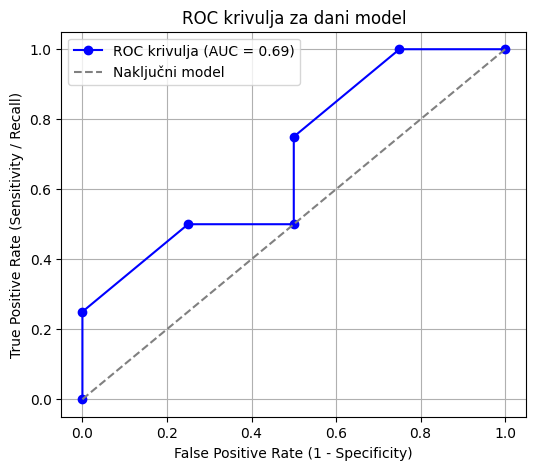

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Podatki
y_true = np.array([1, 0, 1, 0, 1, 1, 0, 0])  # T → 1, F → 0
y_scores = np.array([0.9, 0.7, 0.7, 0.5, 0.3, 0.2, 0.2, 0.1])

# Izračun točk ROC krivulje
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Izris
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', marker='o', label=f'ROC krivulja (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Naključni model')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity / Recall)')
plt.title('ROC krivulja za dani model')
plt.legend()
plt.grid(True)
plt.show()

ROC krivuljo dobiš tako, da postopno spuščaš prag (threshold)
in pri vsakem pragu izračunaš: TPR in FPR

2.b: Koliko je točnost modela iz 2.a glede na metriko ROC-AUC.

In [5]:
from sklearn.metrics import roc_auc_score


y_true = [1, 0, 1, 0, 1, 1, 0, 0]
y_score = [0.9, 0.7, 0.7, 0.5, 0.3, 0.2, 0.2, 0.1]
roc_auc_score(y_true, y_score)

0.6875

## Naloga 3: Odločitvena drevesa

3.a: Sestavi podatkovno množico, ki bo "šla na roko" odločitvenim drevesom. Pomagaj si s funkcijami `numpy.random.randint` in logičnimi operatorji `numpy.logical_not`, ...

In [6]:
n =1000

x1 = np.random.randint(low=0, high=6, size=n)
x2 = np.random.randint(low=0, high=2, size=n) == 1  #ne intevalu [0, 1)
x3 = np.random.randint(low=0, high=2, size=n) 
# Združimo v matriko X
X = np.column_stack([x1, x2, x3])


y = np.logical_or(np.logical_and(x1 > 4, np.logical_not(x2)), x3 == 0).astype(int)

3.b: Preveri točnost odločitvenih dreves na podatkovni množici iz naloge 3.a. Za vsak vzorec prečnega preverjanja izriši tabela napačnih klasifikacij (confusion matrix).

<details>
  <summary>Namig:</summary>

  *Pomagaj si z [objektom sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) in [objektom sklearn.tree.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)*.
   
</details>

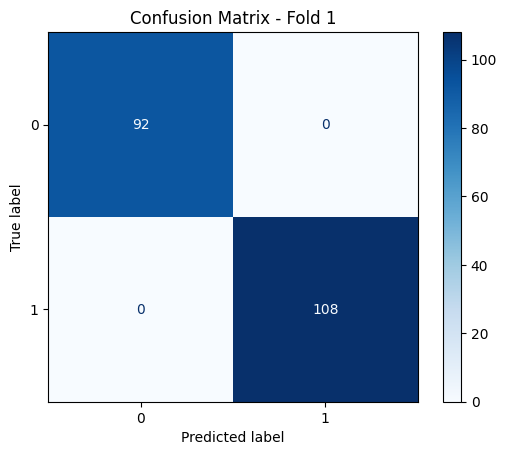

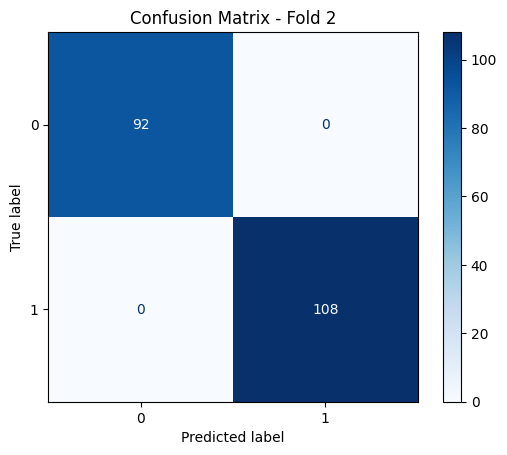

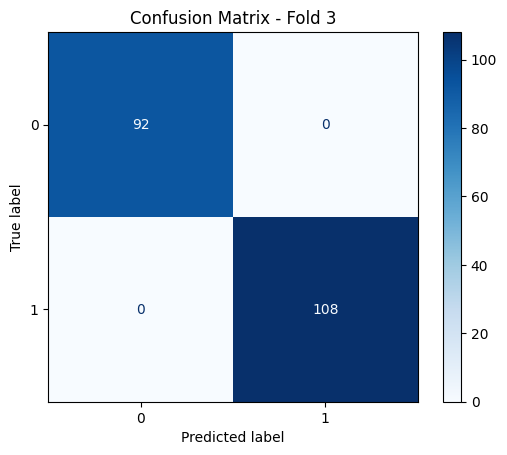

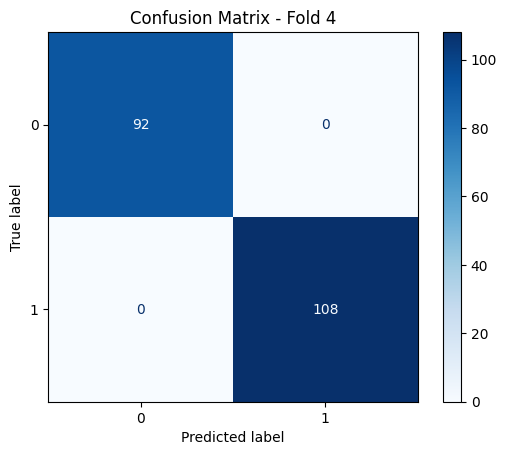

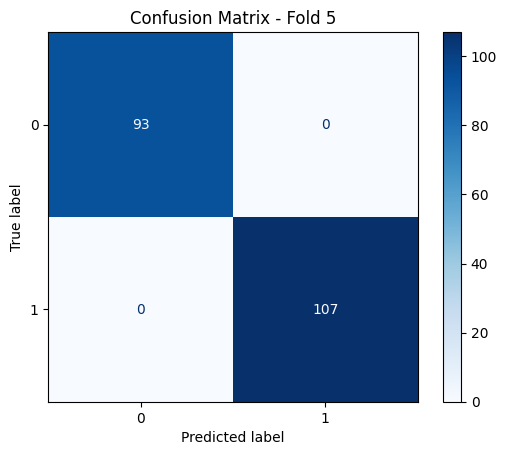

Povprečna točnost: 1.0
Varianca točnosti: 0.0


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


skf = StratifiedKFold()
accuracies = []


i=0

for ind_train, ind_test in skf.split(X, y):
    i += 1

    X_train, X_test = X[ind_train], X[ind_test]
    y_train, y_test = y[ind_train], y[ind_test]

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {i}")
    plt.show()

    accuracies.append(accuracy_score(y_test, y_pred))




print("Povprečna točnost:", np.mean(accuracies))
print("Varianca točnosti:", np.var(accuracies))






3.c: Natreniraj model odločitvenih dreves na vseh podatkih in drevo vizualiziraj. Lahko v nastalem drevesu najdete vsa pravila iz naloge 3.a?

<details>
  <summary>Namig:</summary>

  *Pomagaj si z [objektom sklearn.tree.plot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)*.
   
</details>

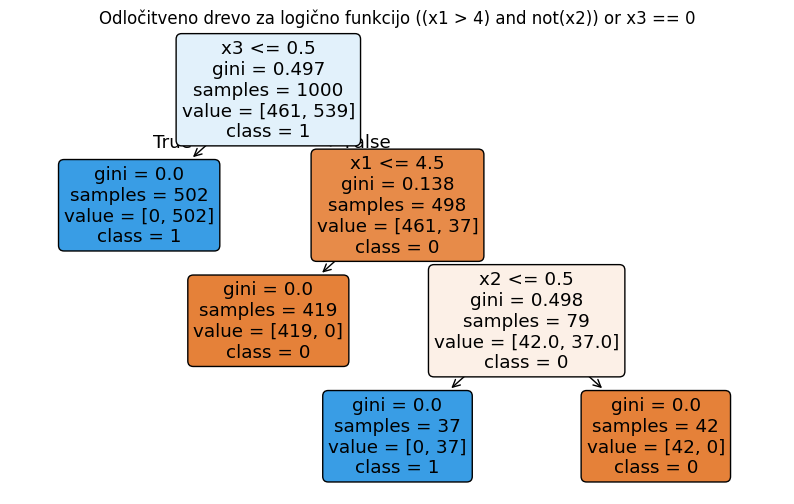

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import  plot_tree

model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)

# --- 3. Vizualizacija drevesa ---
plt.figure(figsize=(10, 6))
plot_tree(
    model,
    feature_names=["x1", "x2", "x3"],
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.title("Odločitveno drevo za logično funkcijo ((x1 > 4) and not(x2)) or x3 == 0")
plt.show()

3.d: Naključno izberi 5 vrstic iz podatkovne množice in jim spremeni ciljno vrednost. Natreniraj model odločitvenih dreves z višino največ 4 in ga ponovno vizualiziraj. Vidiš kakšno razliko v listih drevesa?

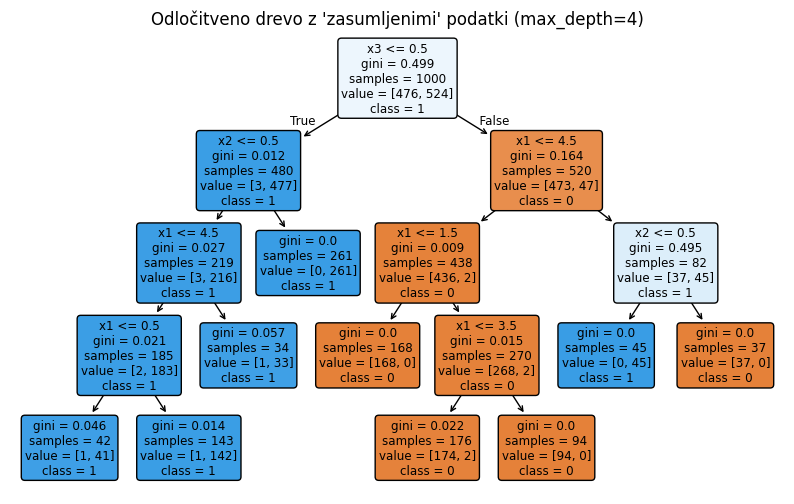

In [26]:
n =1000

x1 = np.random.randint(low=0, high=6, size=n)
x2 = np.random.randint(low=0, high=2, size=n) == 1  #ne intevalu [0, 1)
x3 = np.random.randint(low=0, high=2, size=n) 
# Združimo v matriko X
X = np.column_stack([x1, x2, x3])


y = np.logical_or(np.logical_and(x1 > 4, np.logical_not(x2)), x3 == 0).astype(int)

# Naključno zamenjamo 5 vrednosti y
np.random.seed(1)
indices_to_flip = np.random.choice(len(y), size=5, replace=False)
y_noisy = y.copy()
y_noisy[indices_to_flip] = 1 - y_noisy[indices_to_flip]  # spremeni 0→1 in 1→0


#  Natrenirajmo drevo z omejitvijo višine (max_depth=4)
model_noisy = DecisionTreeClassifier(max_depth=4, random_state=42)
model_noisy.fit(X, y_noisy)


# --- 4. Vizualizacija drevesa ---
plt.figure(figsize=(10, 6))
plot_tree(
    model_noisy,
    feature_names=["x1", "x2", "x3"],
    class_names=["0", "1"],
    filled=True,
    rounded=True
)
plt.title("Odločitveno drevo z 'zasumljenimi' podatki (max_depth=4)")
plt.show()
